In [40]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Some basic EDA

In [41]:
file_path = 'JobLevelData.xlsx'
data = pd.read_excel(file_path)

data.head()


,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


In [43]:
print(f"Data info: {data.info()}")
print("\n")
print(f"Null count: \n{data.isnull().sum()}")
print("\n")
print(f"Unique values: \n{data.nunique()}")
print("\n")
print(f"Number of duplicate rows: {data.nunique()}")
print("\n")
print(f"Dataset describe: \n{data.describe()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     2240 non-null   object
 1   Column 1  2230 non-null   object
 2   Column 2  133 non-null    object
 3   Column 3  12 non-null     object
 4   Column 4  11 non-null     object
dtypes: object(5)
memory usage: 87.6+ KB
Data info: None


Null count: 
Title          0
Column 1      10
Column 2    2107
Column 3    2228
Column 4    2229
dtype: int64


Unique values: 
Title       2240
Column 1       6
Column 2       4
Column 3       2
Column 4       1
dtype: int64


Number of duplicate rows: Title       2240
Column 1       6
Column 2       4
Column 3       2
Column 4       1
dtype: int64


Dataset describe: 
                                                   Title  \
count                                               2240   
unique                                              2240   
top     Vice Pr

In [45]:
columns_to_check = ['Column 1', 'Column 2', 'Column 3', 'Column 4']
for column in columns_to_check:
    print(f"Unique values in {column}:")
    print(data[column].unique())
    print()

Unique values in Column 1:
['Vice President' 'Manager' 'Director' 'Chief Officer' 'Owner' nan
 'Individual Contributor/Staff']

Unique values in Column 2:
[nan 'Individual Contributor/Staff' 'Chief Officer' 'Manager' 'Director']

Unique values in Column 3:
[nan 'Individual Contributor/Staff' 'Director']

Unique values in Column 4:
[nan 'Director']




#Based on the exploratory data analysis of the dataset, the following insights were observed:

##Dataset Overview:
The dataset contains 2240 rows and 5 columns.
All columns are of the object (string) data type, and there are varying levels of missing data across the columns.

##Missing Data:
Title has no missing values.
Column 1 has 10 missing values (0.45% of the total rows).
Column 2 has a significant amount of missing data (2107 missing values, 94% of the rows).
Column 3 and Column 4 are highly sparse, with only 12 non-null values (0.54%) and 11 non-null values (0.49%), respectively.

##Unique Values:
Title has 2240 unique values, indicating no duplicates in this column, which might represent a unique identifier or highly specific titles.
Column 1 contains 6 unique values, with the most frequent value being "Individual Contributor/Staff" (1039 occurrences, nearly half of the rows).
Column 2 has only 4 unique values, and "Individual Contributor/Staff" is also the most frequent value here (55 occurrences).
Column 3 has 2 unique values, with "Individual Contributor/Staff" being dominant (11 out of 12 non-null rows).
Column 4 has 1 unique value, "Director," present in all 11 non-null rows.

##Duplicate Rows:
There are no duplicate rows in the dataset, as all Title values are unique.

Data Sparsity:
Columns Column 3 and Column 4 are extremely sparse, with only 12 and 11 non-null values, respectively. These columns may not provide significant insights for analysis unless the sparse data is critical for specific use cases.

Categorical Distribution:
The dataset is heavily skewed towards a few values in Column 1 and Column 2. For instance, "Individual Contributor/Staff" appears frequently in multiple columns, indicating it might be a common designation or role in the data.



# Data preprocessing
For this step, I simply decided to combine all column labels into one column. This reduces the complexity by reducing the number of features. Since the columns may have common items, the resulting column wil simply be a vector of labels. Each title would have an array of labels associated. If a null value is found, it is replaced with an empty string.

In [47]:
# Data preprocessing: Combine label columns into a single list per row
# Replace NaN values with empty strings for easier processing
data.fillna("", inplace=True)

# Combine all label columns into a single 'Labels' column as a list
data['Labels'] = data[['Column 1', 'Column 2', 'Column 3', 'Column 4']].values.tolist()
data['Labels'] = data['Labels'].apply(lambda labels: [label for label in labels if label])
data_cleaned = data[['Title', 'Labels']]

data_cleaned.head()


,Title,Labels
0,Vice President / Director of Systems Engineering,[Vice President]
1,Systems Engineer; Systems Architect,"[Manager, Individual Contributor/Staff]"
2,"Executive Director, Global IT Infrastructure /...","[Director, Chief Officer]"
3,CTO/Executive Director of Technology Services,"[Director, Chief Officer]"
4,"Vice President, CIO",[Vice President]


# Baseline model
It is alwasy a good idea to begin with a simple baseline model before proceeding with more advanced models.
For this, I begun testing with a RandomForestClassifier.

The process begins by vectorizing the textual data using the TfidfVectorizer. This step converts the text data in the Title column into numerical feature representations, limiting the number of features to the top 5000 terms and removing common stop words in English. This ensures computational efficiency while retaining significant textual information.

Next, the multi-label target values from the Labels column are binarized using MultiLabelBinarizer. This transforms the list of labels for each instance into a binary matrix format, suitable for training a multi-label classification model.

The dataset is then split into training and test sets using an 80-20 ratio, ensuring a consistent random seed for reproducibility. The training set is used to fit a OneVsRestClassifier wrapping a RandomForestClassifier. The Random Forest model is configured with 100 estimators and a fixed random state to ensure deterministic results. The model learns to predict multiple labels for each instance based on the TF-IDF features.

After training, the model makes predictions on the test set. The performance of the model is evaluated using the Hamming Loss, which measures the fraction of incorrect labels (either false positives or false negatives) across all instances and labels. A classification report is also generated, detailing precision, recall, and F1-score for each label, providing a comprehensive view of the model's performance.

The script calculates confusion matrices for each label using multilabel_confusion_matrix and visualizes them with heatmaps. Each heatmap shows the distribution of true positives, false positives, true negatives, and false negatives for a specific label, aiding in a detailed error analysis. The heatmaps are organized into a grid for clarity, with axes labeled to distinguish actual versus predicted values.

Finally, the layout of the plots is adjusted for readability using plt.tight_layout, and the visualizations are displayed with plt.show. This provides an intuitive understanding of the model's strengths and weaknesses for each label in the dataset.

## Results
The overall results, with a Hamming Loss of 0.0346 and an average F1-score of 0.90, indicate strong performance, particularly for the more frequent labels.

 From the plots, each matrix shows the distribution of true positives, false positives, true negatives, and false negatives.

  High performance for frequent labels: Labels like Individual Contributor/Staff, Vice President, and Director show strong classification performance, with a high number of correct predictions (diagonal values) and relatively few misclassifications.
  
  Class imbalance issues: The Owner label has no positive instances in the dataset, meaning the model was never trained on or predicted this class, highlighting a lack of representation.
  Moderate performance for less frequent labels: Manager and Chief Officer have a noticeable number of false negatives, indicating some difficulty in recognizing these labels.
  
  Minimal false positives: The majority of errors arise from false negatives rather than false positives, meaning the model is more likely to miss a correct label than incorrectly assign one.

Overall, the model performs well for well-represented labels but struggles with underrepresented ones, emphasizing the need for balanced data to improve classification performance.

Hamming Loss: 0.0346
Classification Report:
                               precision    recall  f1-score   support

               Chief Officer       0.90      0.60      0.72        30
                    Director       0.90      0.87      0.89        94
Individual Contributor/Staff       0.96      0.97      0.96       232
                     Manager       0.86      0.53      0.66        45
                       Owner       0.00      0.00      0.00         0
              Vice President       0.91      0.89      0.90        80

                   micro avg       0.93      0.87      0.90       481
                   macro avg       0.75      0.64      0.69       481
                weighted avg       0.93      0.87      0.89       481
                 samples avg       0.91      0.90      0.90       481



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

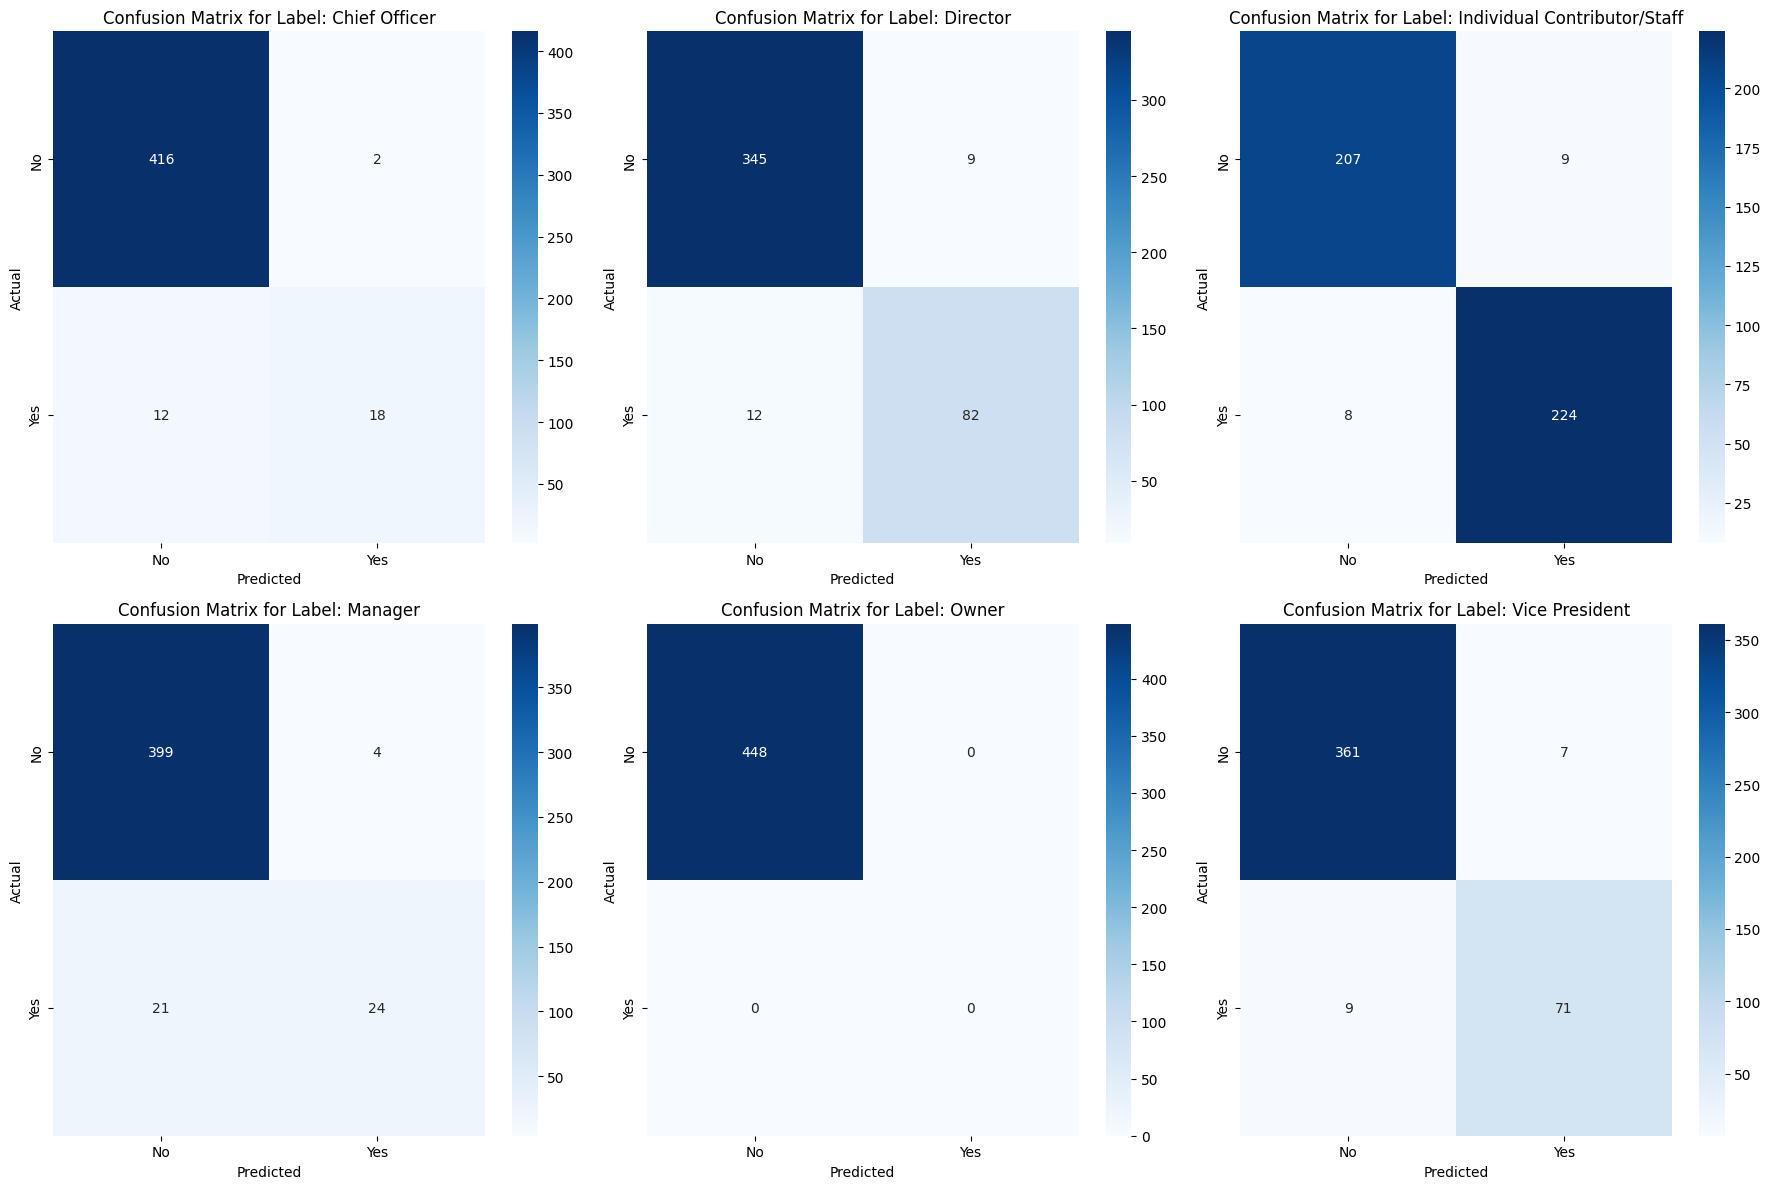

In [49]:
# Tokenization and vectorization is done at this step
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data_cleaned['Title'])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_cleaned['Labels'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print("Classification Report:\n", report)

conf_matrices = multilabel_confusion_matrix(y_test, y_pred, labels=range(len(mlb.classes_)))

# Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for Label: {mlb.classes_[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Adjust layout
plt.tight_layout()
plt.show()


In [6]:
# Total number of labes are presented below
mlb.classes_

array(['Chief Officer', 'Director', 'Individual Contributor/Staff',
       'Manager', 'Owner', 'Vice President'], dtype=object)

# Multilabel NN
Now that there is a baseline mode, it is a proper time to try something more complex. For this purpose, I chose a multi label neural network because it can directly model relationships between labels and is suitable for larger datasets with complex patterns in the data. The tokenization and vectorization step is similar to the baseline model.

The model consists of an input layer, two hidden layers with ReLU activations, and an output layer with a sigmoid activation function. The ReLU activation is commonly used in hidden layers because it introduces non-linearity, allowing the model to learn more complex patterns. Dropout is applied after each hidden layer to prevent overfitting by randomly disabling a fraction of the neurons during training. A dropout rate of 0.3 is chosen here, meaning 30% of the neurons are dropped out at each dropout layer, which is a typical value to achieve regularization without excessively reducing the model's capacity.

The output layer has the same number of units as the number of labels (output_dim), with a sigmoid activation for each label. The sigmoid function is suitable for multi-label classification because it outputs a probability between 0 and 1 for each label, indicating the likelihood that the input belongs to that label. Since this is a multi-label problem, the sigmoid function is used instead of softmax, which would be more appropriate for multi-class problems where only one label can be true for each instance.

The model is compiled using the Adam optimizer, which is a popular choice due to its adaptive learning rate and efficient performance in practice. The loss function used is binary cross-entropy, which is ideal for multi-label classification problems. This loss function treats each label as an independent binary classification problem and calculates the error for each label separately. It is appropriate here because it computes the difference between the predicted probability and the actual binary label (0 or 1) for each label in the multi-label setup.

During training, the model is fit using the training data (X_train and y_train), with the input data converted to dense format using .toarray() to ensure compatibility with TensorFlow. The training runs for 10 epochs with a batch size of 32, meaning the model processes 32 samples at a time before updating its weights. The validation data is provided using X_test and y_test to monitor the model's performance on unseen data during training.

After training, the model is evaluated on the test data (X_test and y_test), and the test loss and accuracy are printed. The accuracy metric measures how often the predicted labels match the true labels, providing a measure of the model's overall performance. However, in multi-label classification, other metrics such as Hamming loss or F1-score may be more informative depending on the problem at hand.

In conclusion, the model performs reasonably well in the multi-label classification task, with an overall Hamming Loss of 0.0465, indicating that the model makes relatively few incorrect predictions. The classification report reveals that the model exhibits strong performance in predicting certain labels, especially Director and Individual Contributor/Staff, with high precision, recall, and F1-scores. For these classes, the model correctly identifies a large proportion of positive instances, as seen in the high recall scores.

However, performance varies significantly across different labels. For instance, the Manager label shows relatively lower performance with precision and recall values around 0.72 and 0.40, respectively, which suggests the model struggles to correctly predict this category. The Owner class has an F1-score of 0.00, likely due to a lack of samples for this class in the dataset, as indicated by the support value of 0.

The micro average scores show an overall accuracy of 90%, which reflects good general performance across all labels. The macro average indicates a more balanced but lower performance, suggesting that some classes are harder to predict than others. The weighted average gives a sense of how the model performs across all classes while accounting for class imbalance, showing strong overall accuracy but lower recall for less frequent labels.

To further improve the model, additional steps such as addressing class imbalance, fine-tuning the model, or using different metrics (such as weighted F1-score) might help to enhance its performance, especially for underperforming classes like Manager and Owner.

In [70]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data_cleaned['Title'])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_cleaned['Labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (1792, 1275), (1792, 6)
Testing set shape: (448, 1275), (448, 6)


In [62]:
# Define the neural network architecture
def build_multi_label_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Input layer with shape matching TF-IDF features
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # For multi label classfication
        metrics=['accuracy']
    )
    return model

# Build the model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = build_multi_label_model(input_dim, output_dim)

# Train the model
history = model.fit(
    X_train.toarray(), y_train,  # Convert sparse matrix to dense for TensorFlow
    validation_data=(X_test.toarray(), y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate the model
results = model.evaluate(X_test.toarray(), y_test, verbose=1)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3339 - loss: 0.6425 - val_accuracy: 0.5112 - val_loss: 0.3938
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4914 - loss: 0.3820 - val_accuracy: 0.5848 - val_loss: 0.3123
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6691 - loss: 0.2956 - val_accuracy: 0.7991 - val_loss: 0.2170
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8206 - loss: 0.1926 - val_accuracy: 0.8482 - val_loss: 0.1669
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8747 - loss: 0.1387 - val_accuracy: 0.8683 - val_loss: 0.1461
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9055 - loss: 0.1141 - val_accuracy: 0.8750 - val_loss: 0.1357
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9141 - loss: 0.0979 - val_accuracy: 0.8795 - val_loss: 0.1314
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9363 - loss: 0.0804 - val_accuracy: 0.8795 - val_lo

In [65]:
# Predict probabilities for test data
y_pred_prob = model.predict(X_test.toarray())

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming:.4f}")


report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print("Classification Report:\n", report)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Hamming Loss: 0.0465
Classification Report:
                               precision    recall  f1-score   support

               Chief Officer       0.79      0.37      0.50        30
                    Director       0.92      0.82      0.87        94
Individual Contributor/Staff       0.93      0.96      0.94       232
                     Manager       0.72      0.40      0.51        45
                       Owner       0.00      0.00      0.00         0
              Vice President       0.91      0.88      0.89        80

                   micro avg       0.90      0.83      0.86       481
                   macro avg       0.71      0.57      0.62       481
                weighted avg       0.89      0.83      0.85       481
                 samples avg       0.86      0.85      0.85       481



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

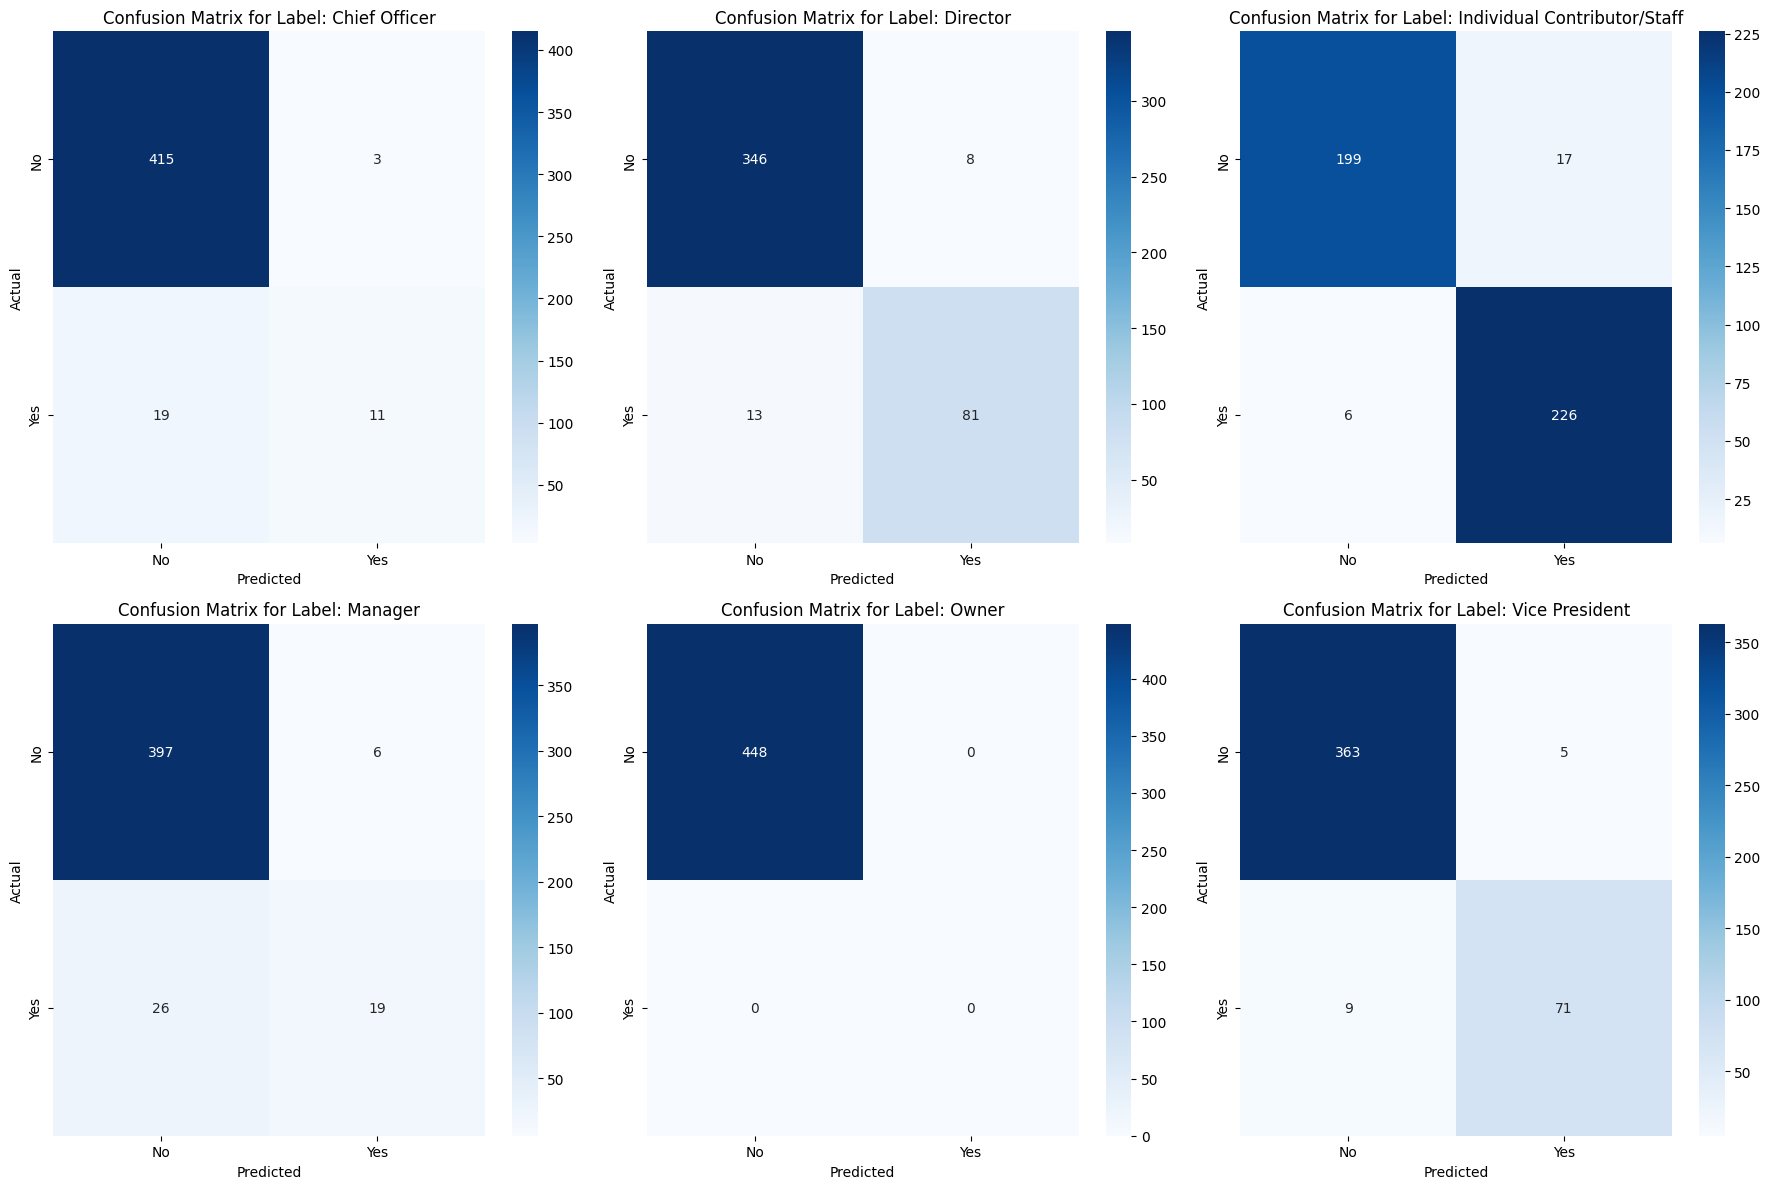

In [64]:
# Generate confusion matrices for all labels
conf_matrices = multilabel_confusion_matrix(y_test, y_pred, labels=range(len(mlb.classes_)))

# Plot confusion matrices for all labels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for Label: {mlb.classes_[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


# Predict labels
Below is a custom function implementation for user given Title value. The fuction uses a trained model to classify betwee, zero, one or multi labels.

In [69]:
def predict_labels(input_title, trained_vectorizer, trained_model, trained_mlb):
    """
    Predict labels for a given job title.

    Parameters:
    - input_title: str, the job title to classify.
    - trained_vectorizer: the TfidfVectorizer trained on the dataset.
    - trained_model: the trained OneVsRestClassifier (with Random Forest).
    - trained_mlb: the MultiLabelBinarizer trained on the dataset.

    Returns:
    - List of predicted labels.
    """
    try:
        input_vector = trained_vectorizer.transform([input_title])
        print(f"Input vector shape: {input_vector.shape}")

        predicted_binary = trained_model.predict(input_vector)

        predicted_labels = trained_mlb.inverse_transform(predicted_binary)

        return predicted_labels[0] if predicted_labels else []
    except ValueError as e:
        print(f"Error during prediction: {e}")
        return []

# Example: Test with a custom job title
input_title =  "CTO/Data Engineer"
predicted_labels = predict_labels(input_title, vectorizer, rf_model, mlb)
print(f"Input Title: {input_title}")
print(f"Predicted Labels: {predicted_labels}")


Input vector shape: (1, 1275)
Input Title: CTO/Data Engineer
Predicted Labels: ('Chief Officer', 'Individual Contributor/Staff')


#Final conlusion
The NN shows worse results accornding to hamming loss, Hamming Loss: 0.0465 compared to the base model, Hamming Loss: 0.0346. When it comes to metrics like accuracy of F1, it also falls shortly behind the base model. Most probably, it can be imporved by finetuning some hypeparameters but the same can be said about base model, RandomForest.

Due to simplicity, easy of understaning and explaining, I would pick a RandomForest classfier for this particular task.